In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentinelhub import DataCollection, SHConfig, BBox, CRS, SentinelHubRequest, MimeType, \
bbox_to_dimensions, DownloadRequest

import time
import threading
from util import *

### Insert API key and secret from dashboard

In [30]:
CLIENT_ID = '38f3a25e-448b-4fb7-8d86-12dae7ab0136'
CLIENT_SECRET = '0Gf?B{PBWqV,wUhhb)AGjG6-72_;}l/6f5HE,9:4'

config = SHConfig()
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET

### Generate a satellite image given box lat/lon coordinates, time period, and resolution

pixel size = (1167, 777)


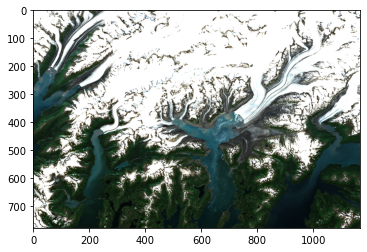

In [5]:
# Alaska
image = get_RGB(box=[-147.8, 60.96, -146.5, 61.38], date='2020-07-15', resolution=60, brighten=True, config=config)
plt.imshow(image);

pixel size = (516, 276)


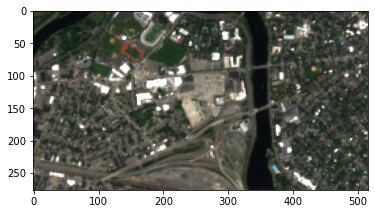

In [4]:
# SEC Harvard
target_box = [-71.137833,42.355306,-71.106934,42.368324]
image = get_RGB(box=target_box, date=('2020-07-15', '2020-07-20'), resolution=5, brighten=True, config=config)
plt.imshow(image);

### Generate an image by specifying a county name, state id, time range, and image dimension

[-71.38471943601648, 42.06064848011287, -70.65316610683927, 42.60327151988714]
pixel size = (1028, 980)


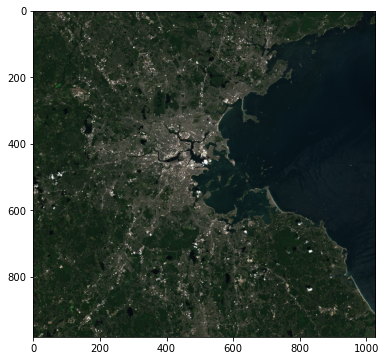

In [15]:
# Suffolk, MA
target_box = get_county_box(county_name='Suffolk', statefp=25, height=60, width=60, county_df=None)
print(target_box)
image = get_RGB(box=target_box, date=('2020-07-15', '2020-07-20'), resolution=60, brighten=True, config=config)
plt.figure(figsize=[10, 6])
plt.imshow(image);

[-105.63796885450971, 39.501115733521445, -104.4621548993939, 40.40548746647856]
pixel size = (1675, 1672)


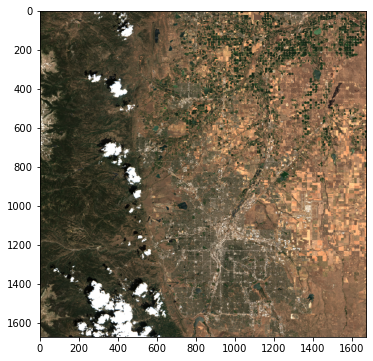

In [37]:
# Broomfield, CO
target_box = get_county_box(county_name='Broomfield', statefp=8, height=100, width=100, county_df=None)
print(target_box)
image = get_RGB(box=target_box, date=('2020-07-15', '2020-07-20'), resolution=60, config=config)
plt.figure(figsize=[10, 6])
plt.imshow(image);

### Use a cloud probablity associated with each pixel to detect clouds in the image

[-105.63796885450971, 39.501115733521445, -104.4621548993939, 40.40548746647856]
pixel size = (1675, 1672)


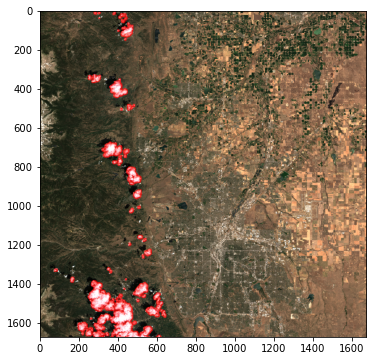

In [3]:
target_box = get_county_box(county_name='Broomfield', statefp=8, height=100, width=100, county_df=None)
print(target_box)
image = get_RGB(box=target_box, date=('2020-07-15', '2020-07-20'), resolution=60, config=config)
plt.figure(figsize=[10, 6])
plt.imshow(image);

### Use a multithreading for handling mutile timestamps and counties

In [ ]:
def get_RGB_thread(box, date, resolution, config=None):
    time.sleep(0.1)
    bbox = BBox(box, crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution=resolution)
    
    evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [2*sample.B04, 2*sample.B03, 2*sample.B02];
    }
    """

    if not config:
        CLIENT_ID = '38f3a25e-448b-4fb7-8d86-12dae7ab0136'
        CLIENT_SECRET = '0Gf?B{PBWqV,wUhhb)AGjG6-72_;}l/6f5HE,9:4'
        config = SHConfig()
        config.sh_client_id = CLIENT_ID
        config.sh_client_secret = CLIENT_SECRET
        
    request[date] = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=date,
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=bbox,
        size=size,
        config=config
    )
    image[date] = request[date].get_data()[0]
    lock.acquire()
    temp.append((date, image[date]))
    lock.release()

In [61]:
temp = []
target_box = get_county_box(county_name='Broomfield', statefp=8, height=200, width=200, county_df=None)
timerange = []
for i in [2018]:
    i = str(i)
    for j in range(1, 13):
        j = str(j)
        if len(j) == 1:
            j = '0' + j
        timerange.append((i + '-' + j + '-01', i + '-' + j + '-28'))

In [62]:
%%time
request = {}
image = {}
lock = threading.Lock()
threads = [threading.Thread(target=get_RGB_thread, args=((target_box), (elt), (200), (config))) for elt in timerange]

for t in threads:
    t.start()
for t in threads:
    t.join()

CPU times: user 1.2 s, sys: 217 ms, total: 1.42 s
Wall time: 9.7 s


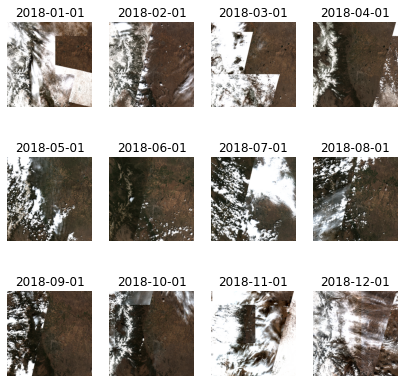

In [64]:
temp.sort(key=lambda x: x[0][0])
fig = plt.figure(figsize=[7, 7])
for i, elt in enumerate(temp):
    # print(elt[0])
    ax = fig.add_subplot(3, 4, i+1)
    temp.sort(key=lambda x: x[0][0])
    # plt.subplot(5, 5, i+1)
    ax.imshow(elt[1])
    ax.axis('off')
    ax.set_title(elt[0][0])